In [6]:
import cv2
import sklearn.mixture
import matplotlib.pyplot as plt
import numpy as np
import igraph

# Grabcut assignment
## Grabcut class defined here

### Implementation details

 - The code has classes 
     - class 0 - background
     - class 1 - probably background
     - class 2 - probably foreground
     - class 3 - foreground
     
 - First select the bounding box which becomes the probable foreground class.
 - Learn two GMM models 
     - Foreground (class 2 and class 3)
     - Background (class 0 and class 1)
 - Depending on the class labels edges from source, sink and neighboring nodes are weighted.
 
 - We first construct the graph with number of image pixels + 2 nodes (source and sink).
 
 - We know the probable foreground nodes and background nodes in the first iteration.

 - Edge weights assigned given class
     - class 0 
         - Sink - pixel - K
         - Source - pixel - 0
         - pixel - pixel - 0 (if class 0 or 1)
         - pixel - pixel - neigboring penalty
     - class 1
         - Sink - pixel - negative log likelihood (foreground)
         - Source - pixel - negative log likelihood (background)
         - pixel - pixel - 0 (if class 0 or 1)
         - pixel - pixel - neigboring penalty
     - class 2 
         - Sink - pixel - negative log likelihood (foreground)
         - Source - pixel - negative log likelihood (background)
         - pixel - pixel - 0 (if class 3 or 2)
         - pixel - pixel - neigboring penalty
     - class 3 
         - Sink - pixel - 0
         - Source - pixel - K
         - pixel - pixel - 0 (if class 2 or 3)
         - pixel - pixel - neigboring penalty         
 - Once the graph is constructed with edge weights we perform source terminal mincut. This partitions the graph into 2 parts. 
 - The above is repeated until convergence.



     

In [7]:
class GrabCut:
    def __init__(self, image, gamma = 50, option = 0, num_components = 5, conv_threshold = 0.1, disp_output = 0, bbox = None):
        
        '''
        Class constructor
        Input:
            image - H x W x 3 - input image
            conv_threshold - scalar - convergence threshold for grabcut
            bbox - list - bounding box coordinates
            gamma - scalar - gamma value for grabcut
            option - scalar 
                0 - 4 neighborhood
                1 - 8 neighborhood
            num_components - scalar - number of gaussian components
            disp_output - scalar - 1) shows intermediate outputs
                                   0) does not show intermediate results
        Returns:
            None
        '''
        self.threshold = conv_threshold
        self.disp = disp_output
        self.image = image
        if bbox is None:
            r = cv2.selectROI(self.image) 
            bbox = [r[0], r[1], r[0] + r[2], r[1] + r[3]]
            self.bbox = bbox
        else:
            self.bbox = bbox
            
        self.option = option
        self.x1 = int(bbox[0])
        self.x2 = int(bbox[2])
        self.y1 = int(bbox[1])
        self.y2 = int(bbox[3])
        
        self.gamma = gamma
        self.mask = None
        self.graph = None
        self.num_components = num_components
        
        self.bg_gmm = None
        self.fg_gmm = None
        
        self.create_mask_init()
        self.create_graph_image()
        cv2.destroyAllWindows()
        
    def create_mask_init(self):
        '''
        Creates initial mask
            0 - bg
            1 - probably bg
            2 - probably fg
            3 - fg
        '''
        
        mask = np.zeros((self.image.shape[0], self.image.shape[1]))
        mask[ self.y1:self.y2, self.x1:self.x2] = 2
        self.mask = mask
        
    
    def GMMPrediction(self):
        '''
        Function to cluster images sections using gaussian mixture models  
        '''
        image = self.image
        mask = self.mask
        
        bg_mask = np.logical_or(mask == 0 , mask == 1)
        fg_mask = np.logical_or(mask == 2 , mask == 3)
        
        
        image_mask_vector_bg = image[bg_mask, :]
        image_mask_vector_fg = image[fg_mask, :]
        
        gmm_model_bg = sklearn.mixture.GaussianMixture(n_components = self.num_components).fit(image_mask_vector_bg)
        gmm_model_fg = sklearn.mixture.GaussianMixture(n_components = self.num_components).fit(image_mask_vector_fg)

        image_vector = image.reshape((-1, 3))

        neg_log_likelihood_bg = -gmm_model_bg.score_samples(image_vector)
        neg_log_likelihood_fg = -gmm_model_fg.score_samples(image_vector)

        self.bg_gmm = neg_log_likelihood_bg.reshape((image.shape[0], image.shape[1]))
        self.fg_gmm = neg_log_likelihood_fg.reshape((image.shape[0], image.shape[1]))
        
    
    
    def create_graph_image(self):
        '''
        Function to create graph of image
        '''
        
        self.graph = igraph.Graph()
        self.graph.add_vertices(self.image.shape[0] * self.image.shape[1] + 2)
    
    def calc_beta_value(self):
        '''
        Function to calculate beta value used in neighboring edge weight
        '''

        image = self.image
        height = image.shape[0]
        width = image.shape[1]

        diff_up = np.sum(np.sum(np.square(image[1:height - 1, :] - image[:height - 2, :]), axis = 2))
        diff_side = np.sum(np.sum(np.square(image[:, 1:width - 1] - image[:, :width - 2]), axis = 2))
        diff_diag = np.sum(np.sum(np.square(image[1:height - 1, 1:width - 1] - image[:height - 2, :width - 2]), axis = 2))
        diff_lower_diag = np.sum(np.sum(np.square(image[:height - 2, 1:width - 1] - image[1:height - 1, :width - 2]), axis = 2))

        # 2 * (h - 1)(w - 1) + (h - 1)w + (w - 1)h = 4hw - 3h - 3w + 2
        beta = (1 / 2) * (2 * (height - 1) * (width - 1) + height * (width - 1) + (height - 1) * width ) * (1 / (diff_diag + diff_lower_diag + diff_up + diff_side))

        return beta
    
    def add_graph_edges(self):
        '''
        Function to add edges and their respective weights to th graph
        '''
        
        beta = self.calc_beta_value()
        image = self.image
        height = image.shape[0]
        width = image.shape[1]
        
        sink_node = int(image.shape[0]*image.shape[1] + 1)
        source_node = int(0)
        
        gamma = self.gamma
        edges = []
        weights = []
        mask = self.mask
        
        for row in range(height):
            for column in range(width):
        
                # bottom pixel weight

                if (row + 1) < height:
                    edges.append((row*width + column + 1, (row + 1)*width + column + 1))

                    if mask[row + 1, column] == mask[row, column] or (mask[row + 1, column] == 0 and mask[row, column] == 1) or (mask[row + 1, column] == 1 and mask[row, column] == 0) or (mask[row + 1, column] == 3 and mask[row, column] == 2) or (mask[row + 1, column] == 2 and mask[row, column] == 3):
                        weights.append(0)
                    else:
                        weights.append(gamma*np.exp(-beta * np.sum(np.square(image[row + 1, column] - image[row, column]))))

                #right pixel
               
                if (column + 1) < width:
                    edges.append((row*width + column + 1, (row)*width + column + 2))

                    if mask[row, column + 1] == mask[row, column] or (mask[row, column + 1] == 0 and mask[row, column] == 1) or (mask[row, column + 1] == 3 and mask[row, column] == 2) or (mask[row, column + 1] == 2 and mask[row, column] == 3) or (mask[row, column + 1] == 1 and mask[row, column] == 0):
                        weights.append(0)
                    else:
                        weights.append(gamma*np.exp(-beta * np.sum(np.square(image[row, column + 1] - image[row, column]))))

                # diagonal pixel
                
                if (column + 1) < width and (row + 1) < height and self.option == 1:
                    edges.append(((row + 1)*width + column + 2, (row)*width + column + 1))

                    if mask[row + 1, column + 1] == mask[row, column] or (mask[row + 1, column + 1] == 0 and mask[row, column] == 1) or (mask[row + 1, column + 1] == 1 and mask[row, column] == 0) or (mask[row + 1, column + 1] == 3 and mask[row, column] == 2) or (mask[row + 1, column + 1] == 2 and mask[row, column] == 3):
                        weights.append(0)
                    else:
                        weights.append(gamma*np.exp(-beta * np.sum(np.square(image[row + 1, column + 1] - image[row, column]))))

        K = 1 + max(weights)
        
        
        for row in range(height):
            for column in range(width):
                
                if mask[row, column] == 1 or mask[row, column] == 2:
                    edges.append((source_node, int(row*width + column + 1)))
                    weights.append(self.bg_gmm[ row, column])

                    edges.append((sink_node, int(row*width + column + 1)))
                    weights.append(self.fg_gmm[ row, column])
                
                elif mask[row, column] == 0:
                    edges.append((source_node, int(row*width + column + 1)))
                    weights.append(0)

                    edges.append((sink_node, int(row*width + column + 1)))
                    weights.append(K)
                else:
                    edges.append((source_node, int(row*width + column + 1)))
                    weights.append(K)

                    edges.append((sink_node, int(row*width + column + 1)))
                    weights.append(0)

                
        
        self.graph.add_edges(edges)
        self.graph.es['weight'] = weights

    def update_mask(self, partition_source):
        '''
        Update mask after st mincut
        ''' 
        init_mask = self.mask
        mask = np.zeros((self.image.shape[0], self.image.shape[1]))
        mask[ self.y1:self.y2, self.x1:self.x2] = 1
        mask2 = mask.copy()
        mask2[self.y1:self.y2, self.x1:self.x2] = 1
        bbox_width = image.shape[1]
        
        # removing source node from partition
        partition_source = np.array(partition_source, dtype = int)
        
        
        partition_source = partition_source - 1
        mask_partition = partition_source >= 0
        
        partition_source = partition_source[mask_partition]
        
        
        fg_row = partition_source // bbox_width
        fg_col = partition_source % bbox_width

        mask[fg_row, fg_col] = 2
        mask[np.where(init_mask) == 3] = 3
        self.mask = mask * mask2 
    
    def generate_image_mask(self):
        '''
        Generate segmented image
        '''
        
        masked_image = np.zeros(self.image.shape)
        mask = np.logical_or(self.mask == 2, self.mask == 3) * 1
        for i in range(3):
            masked_image[:, :, i] = self.image[:, :, i] * mask
        masked_image = masked_image.astype('uint8')
        
        return masked_image
        
    def grabCut(self):
        
        '''
        Function performs grabcut
        Input:
            Class object
        Returns:
            masked_image - H x W x 3 - image containing foreground only
        
        '''
        running = True
        i = 0
        while running:
            self.GMMPrediction()
            self.add_graph_edges()
            mc = self.graph.st_mincut( int(0), image.shape[0]*image.shape[1] + 1, self.graph.es['weight'])
            
            if i != 0:
                threshold = (mc.value - E_init) / mc.value
                print(threshold)
                if threshold < self.threshold:
                    running = False
                
            E_init = mc.value
            partition_source, partition_terminal = mc.partition
            self.update_mask(partition_source)
            i = i + 1
            masked_image = self.generate_image_mask()
            masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
            if self.disp == 1:
                plt.imshow(masked_image)
                plt.show()

        return masked_image
        

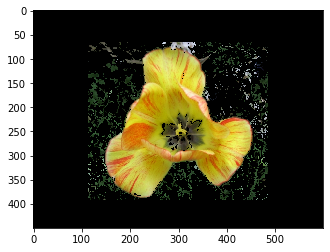

KeyboardInterrupt: 

In [8]:
if __name__ == "__main__":
    
    name = 'flower'
    image_name = './data/images/%s.jpg' % (name)
    bbox_name = './data/bboxes/%s.txt' % (name)
    bbox = np.loadtxt(bbox_name, delimiter = ' ')
    image = cv2.imread(image_name)
    gamma = 50
    option = 0
    num_components = 5
    convergence_threshold = 0.1
    print_output = 1
    grabcut_object = GrabCut(image, gamma, option, num_components, convergence_threshold, print_output)
    image_output = grabcut_object.grabCut()

### Testing with 8 neighbors
#### Inference
    - With 8 neighbors the foreground segmentation is more uniform diagonally 

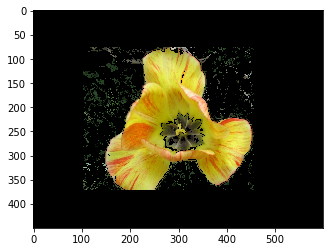

0.48784311639911937


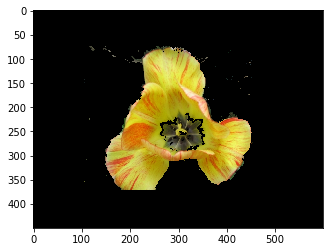

0.3276402273521335


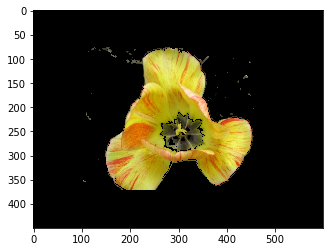

0.25019220244636836


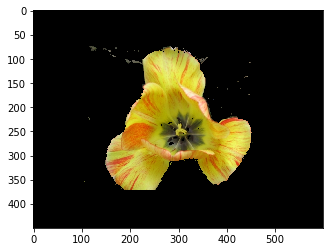

0.19809750603803203


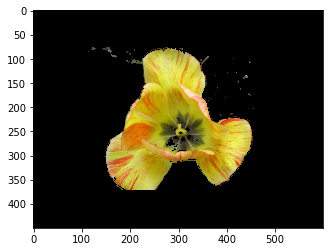

0.1682033655744191


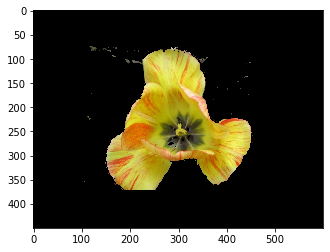

0.14034618541618352


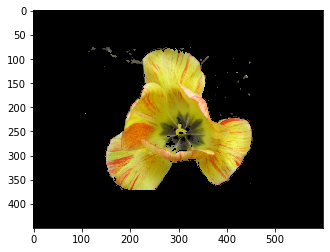

0.12733181461437545


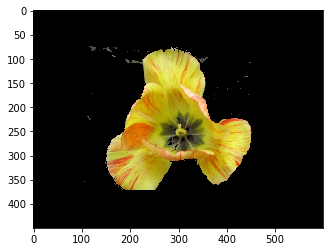

0.10982823742887424


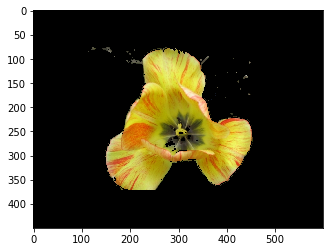

0.10051433427503613


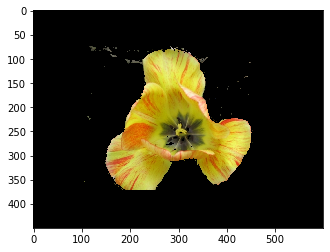

0.09031618583009131


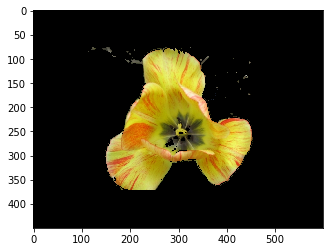

In [7]:
    name = 'flower'
    image_name = './data/images/%s.jpg' % (name)
    bbox_name = './data/bboxes/%s.txt' % (name)
    bbox = np.loadtxt(bbox_name, delimiter = ' ')
    image = cv2.imread(image_name)
    gamma = 50
    option = 1
    num_components = 5
    convergence_threshold = 0.1
    print_output = 1
    grabcut_object = GrabCut(image, gamma, option, num_components, convergence_threshold, print_output)
    image_output = grabcut_object.grabCut()

### Testing with higher value of gamma
#### Inference
    - Giving high gamma value means we are stressing over the neighbors to belong to same class this may not always give the best outputs

0.48722826367366456
0.3291582149590456
0.25005990914366905
0.19816484687373787
0.16708732594467054
0.14145399023205224
0.12576589261663812
0.11056142690712724
0.10080799818767916
0.09000614041396057


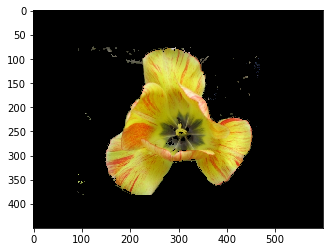

In [8]:
    name = 'flower'
    image_name = './data/images/%s.jpg' % (name)
    bbox_name = './data/bboxes/%s.txt' % (name)
    bbox = np.loadtxt(bbox_name, delimiter = ' ')
    image = cv2.imread(image_name)
    gamma = 100
    option = 0
    num_components = 5
    convergence_threshold = 0.1
    print_output = 0
    grabcut_object = GrabCut(image, gamma, option, num_components, convergence_threshold, print_output)
    image_output = grabcut_object.grabCut()
    plt.imshow(image_output)
    plt.show()

### Varying GMM components
#### GMM component = 1

0.48004695255834995
0.2984890645589716
0.24272279553262927
0.20011467122571516
0.16666146315652355
0.1429198643140213
0.12496023499405283
0.11115309569354133
0.0999602300614365


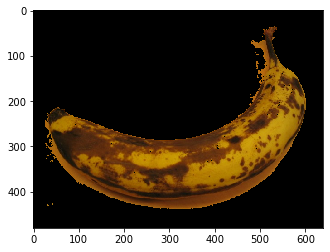

In [9]:
    name = 'banana1'
    image_name = './data/images/%s.jpg' % (name)
    bbox_name = './data/bboxes/%s.txt' % (name)
    bbox = np.loadtxt(bbox_name, delimiter = ' ')
    image = cv2.imread(image_name)
    gamma = 50
    option = 0
    num_components = 1
    convergence_threshold = 0.1
    print_output = 0
    grabcut_object = GrabCut(image, gamma, option, num_components, convergence_threshold, print_output)
    image_output = grabcut_object.grabCut()
    plt.imshow(image_output)
    plt.show()

#### GMM components = 5

0.4835244309625366
0.32738216641414775
0.24934476851369308
0.19871776637329905
0.1666412551857611
0.14235503031675814
0.1254341325165165
0.11065429747657508
0.10010883892281666
0.09066831940429741


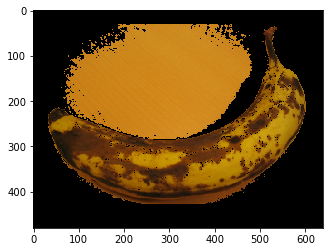

In [10]:
    name = 'banana1'
    image_name = './data/images/%s.jpg' % (name)
    bbox_name = './data/bboxes/%s.txt' % (name)
    bbox = np.loadtxt(bbox_name, delimiter = ' ')
    image = cv2.imread(image_name)
    gamma = 50
    option = 0
    num_components = 5
    convergence_threshold = 0.1
    print_output = 0
    grabcut_object = GrabCut(image, gamma, option, num_components, convergence_threshold, print_output)
    image_output = grabcut_object.grabCut()
    plt.imshow(image_output)
    plt.show()

### Tight bounding box
    - Tighter bounding box gives higher accuracy 
    - With loose bounding box we have more pixels that are not in the foreground as probable foreground. This does not learn the gmm model properly and hence does not give a good enough segmentation.

0.49041299122697846
0.33180842954919404
0.2508846387920136
0.19893331409627926
0.16772006350435364
0.14175244450743651
0.12612353287380462
0.10996793516867336
0.10115597896841295
0.08973993369523252


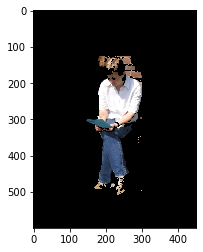

In [11]:
    name = 'person6'
    image_name = './data/images/%s.jpg' % (name)
    bbox_name = './data/bboxes/%s.txt' % (name)
    bbox = np.loadtxt(bbox_name, delimiter = ' ')
    image = cv2.imread(image_name)
    gamma = 50
    option = 1
    num_components = 1
    convergence_threshold = 0.1
    print_output = 0
    grabcut_object = GrabCut(image, gamma, option, num_components, convergence_threshold, print_output)
    image_output = grabcut_object.grabCut()
    plt.imshow(image_output)
    plt.show()

### Loose bounding box

0.47755721295967557
0.33198249241625827
0.2503626144980008
0.1995347047184657
0.16710279546992302
0.14240116942188277
0.12546287591716515
0.11063996167209182
0.10047678609044333
0.09042723352747796


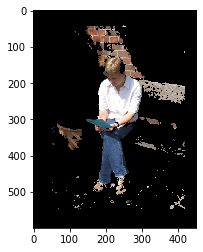

In [12]:
    name = 'person6'
    image_name = './data/images/%s.jpg' % (name)
    bbox_name = './data/bboxes/%s.txt' % (name)
    bbox = np.loadtxt(bbox_name, delimiter = ' ')
    image = cv2.imread(image_name)
    gamma = 50
    option = 1
    num_components = 1
    convergence_threshold = 0.1
    print_output = 0
    grabcut_object = GrabCut(image, gamma, option, num_components, convergence_threshold, print_output)
    image_output = grabcut_object.grabCut()
    plt.imshow(image_output)
    plt.show()

0.4848829345713043
0.33051042938323094
0.24910948967922233
0.19954943994714694
0.16666297824197926
0.14254639411659045
0.12506033325816562
0.11079659538476527
0.10007594768028226
0.09047683591795898


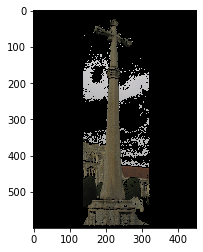

In [13]:
    name = 'cross'
    image_name = './data/images/%s.jpg' % (name)
    bbox_name = './data/bboxes/%s.txt' % (name)
    bbox = np.loadtxt(bbox_name, delimiter = ' ')
    image = cv2.imread(image_name)
    gamma = 50
    option = 0
    num_components = 3
    convergence_threshold = 0.1
    print_output = 0
    grabcut_object = GrabCut(image, gamma, option, num_components, convergence_threshold, print_output)
    image_output = grabcut_object.grabCut()
    plt.imshow(image_output)
    plt.show()

0.4939997990455215
0.3283214037183475
0.2508581012445524
0.19707577983056299
0.16832506790367133
0.14089995889715876
0.12613626422670798
0.10967879541946883
0.10091810145696103
0.08960723419817657


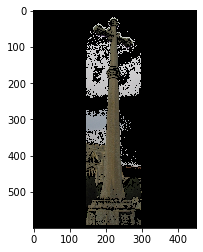

In [14]:
    name = 'cross'
    image_name = './data/images/%s.jpg' % (name)
    bbox_name = './data/bboxes/%s.txt' % (name)
    bbox = np.loadtxt(bbox_name, delimiter = ' ')
    image = cv2.imread(image_name)
    gamma = 50
    option = 0
    num_components = 5
    convergence_threshold = 0.1
    print_output = 0
    grabcut_object = GrabCut(image, gamma, option, num_components, convergence_threshold, print_output)
    image_output = grabcut_object.grabCut()
    plt.imshow(image_output)
    plt.show()

### testing with my own image

0.48405088351616776
0.3295249214759268
0.2503350275430667
0.19816026844742068
0.16771554486540816
0.14128109328902294
0.12618119616672308
0.10963334795923246
0.10123894504915058
0.08944276242329999


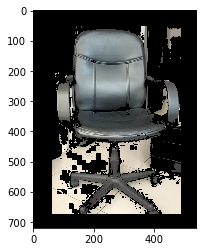

In [15]:
    name = 'chair_image'
    image_name = './data/images/%s.jpg' % (name)
    #bbox_name = './data/bboxes/%s.txt' % (name)
    bbox = np.loadtxt(bbox_name, delimiter = ' ')
    image = cv2.imread(image_name)
    gamma = 50
    option = 0
    num_components = 3
    convergence_threshold = 0.1
    print_output = 0
    grabcut_object = GrabCut(image, gamma, option, num_components, convergence_threshold, print_output)
    image_output = grabcut_object.grabCut()
    plt.imshow(image_output)
    plt.show()